## Importación de Librerías

In [16]:
import open3d as o3d
import numpy as np
import pandas as pd
import os
import re
from glob import glob
import time
import random
import seaborn as sns
import xml.etree.ElementTree as ET
from mpl_toolkits.mplot3d import Axes3D
from pyntcloud import PyntCloud
import plotly.graph_objs as gow
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt 
from plotly.offline import iplot, init_notebook_mode

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import torch.optim as optim


import warnings
warnings.filterwarnings("ignore")

init_notebook_mode(connected=True)
%matplotlib inline

## DataLoader

In [56]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.spatial import cKDTree

category_mapping = {
    0: [7, 22, 9, 26, 11, 21, 51, 50, 5, 18, 23, 3, 24, 31, 2],  # Drivable (Road, Drivable Vegetation, Terrain)
    1: [43, 38, 58, 29, 41, 42, 44, 39, 55,  # Construction
        4, 45, 6, 40, 60, 61, 33, 32, 14,   # Object
        48, 47, 1, 19, 46, 10, 25,         # Sign
        28, 27, 62, 52, 16, 30, 59, 17,    # Non Drivable Vegetation
        13, 15, 12, 36, 57, 49, 20, 35, 37, 34, 63],  # Vehicle
    2: [8, 56, 0, 53, 54],  # Void
}

category_mapping_2 = {
    0: [43, 38, 58, 29, 41, 42, 44, 39, 55], # Construction
    1: [4, 45, 6, 40, 60, 61, 33, 32, 14], # Object
    2: [7, 22, 9, 26, 11, 21], # Road
    3: [48, 47, 1, 19, 46, 10, 25], # Sign
    4: [23, 3, 24, 31, 2], # Terrain  
    5: [51, 50, 5, 18], # Drivable Vegetation
    6: [28, 27, 62, 52, 16, 30, 59, 17], # Non Drivable Vegetation
    7: [13, 15, 12, 36, 57, 49, 20, 35, 37, 34, 63], # Vehicle
    8: [8, 56, 0, 53, 54], # Void
}

# Generar el diccionario inverso para mapear etiquetas
label_to_category = {label: cat for cat, labels in category_mapping_2.items() for label in labels}

# Función para remapear etiquetas
def map_labels(labels: np.ndarray) -> np.ndarray:
    return np.array([label_to_category.get(label, 8) for label in labels], dtype=np.uint8)

def load_bin_file(bin_path: str, num_points: int, radius: float = 25.0, seed: int = None):
    full_points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    points = full_points[:, :3]
    remission = full_points[:, 3]  # Añadir remission (shape: [N, 1])

    distances = np.linalg.norm(points, axis=1)
    mask = distances <= radius
    points = points[mask]
    remission = remission[mask]  # Filtrar remission también
    num_available = points.shape[0]

    if num_available >= num_points:
        if seed is not None:
            np.random.seed(seed)  # Establece semilla si se proporciona
        indices = np.random.choice(num_available, num_points, replace=False)
        return points[indices], remission[indices], np.where(mask)[0][indices]

    return None, None, None

def load_label_file(label_path: str, indices: np.ndarray) -> np.ndarray:
    labels = np.fromfile(label_path, dtype=np.uint32) & 0xFFFF
    return map_labels(labels[indices])

def normalize_point_cloud(points):
    mean = np.mean(points, axis=0)  # Media por dimensión
    std = np.std(points, axis=0) + 1e-6  # Evitar divisiones por 0
    return (points - mean) / std

class GOOSEDataset(Dataset):
    def __init__(self, x_path, y_path, num_points=4096, mode='train', batch_size=32):
        self.x_files = sorted([os.path.join(x_path, f) for f in os.listdir(x_path) if f.endswith(".bin")])
        self.y_files = sorted([os.path.join(y_path, f) for f in os.listdir(y_path) if f.endswith(".label")])
        assert len(self.x_files) == len(self.y_files), "Número de archivos de entrada y etiquetas no coinciden"
        self.num_points = num_points
        self.batch_size = batch_size
        self.mode = mode

    def __len__(self):
        return len(self.x_files)

    def __getitem__(self, idx):
        seed = 42 if self.mode == 'val' else None  # Semilla fija para validación
        
        points, remission, indices = load_bin_file(self.x_files[idx], self.num_points, radius=25.0, seed=seed)

        if points is None or indices is None:
            return self.__getitem__((idx + 1) % len(self.x_files))
        
        labels = load_label_file(self.y_files[idx], indices)

        if labels is None:
            return self.__getitem__((idx + 1) % len(self.x_files))
        
        remission = torch.tensor(remission, dtype=torch.float32)

        return torch.tensor(points, dtype=torch.float32), remission, torch.tensor(labels, dtype=torch.long)

In [57]:
x_train_path = "/home/fmartinez/datasets/goose/lidar/train"
y_train_path = "/home/fmartinez/datasets/goose/labels/train"

x_val_path = "/home/fmartinez/datasets/goose/lidar/train"
y_val_path = "/home/fmartinez/datasets/goose/labels/train"

x_test_path = "/home/fmartinez/datasets_val/lidar/val"
y_test_path = "/home/fmartinez/datasets_val/labels/val"

In [58]:
train_dataset = GOOSEDataset(x_train_path, y_train_path, num_points=16384, mode='train', batch_size=16)
val_dataset = GOOSEDataset(x_val_path, y_val_path, num_points=16384, mode='val', batch_size=16)

In [59]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [21]:
import plotly.graph_objects as go
import pandas as pd

def plot_3D_colors(sampled_df):
    # Define color map for 3 categories
    color_map = {
        0: 'limegreen',  # Drivable (Green for clear zones)
        1: 'red',        # Obstacle (Red for danger/obstacles)
        2: 'gray'        # Void (Gray for undefined points)
    }

    color_map_2 = {
        0: 'yellow',  # Drivable (Green for clear zones)
        1: 'red',        # Obstacle (Red for danger/obstacles)
        2: 'gray',        # Void (Gray for undefined points)
        3: 'black',      # Drivable (Green for clear zones)
        4: 'blue',        # Obstacle (Red for danger/obstacles)
        5: 'green',       # Void (Gray for undefined points)
        6: 'limegreen',  # Drivable (Green for clear zones)
        7: 'purple',        # Obstacle (Red for danger/obstacles)
        8: 'white'        # Void (Gray for undefined points)
    }

    label_categories = [
        'Drvable',  # 0
        'Obstacle',  # 1
        'Void' # 2
    ]

    label_categories_2 = [
        'yellow',  # Drivable (Green for clear zones)
        'red',        # Obstacle (Red for danger/obstacles)
        'gray',        # Void (Gray for undefined points)
        'black',      # Drivable (Green for clear zones)
        'blue',        # Obstacle (Red for danger/obstacles)
        'green',       # Void (Gray for undefined points)
        'limegreen',  # Drivable (Green for clear zones)
        'purple',        # Obstacle (Red for danger/obstacles)
        'white'        # Void (Gray for undefined points)
    ]

    # Map label colors using apply to avoid NaN issues
    scatter_colors = sampled_df['label'].apply(lambda x: color_map_2.get(x, 'gray'))
    scatter_texts = sampled_df['label'].apply(lambda x: label_categories_2[x])  #  Nombre de la clase

    # Create a 3D scatter plot without adding it to the legend
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=sampled_df['x'],
        y=sampled_df['y'],
        z=sampled_df['z'],
        mode='markers',
        marker=dict(
            size=2,  # Ajustar tamaño del punto
            color=scatter_colors,  # Color por categoría
            opacity=0.7  # Ajustar opacidad
        ),
        text=scatter_texts,  #  Se muestra el nombre de la clase al pasar el mouse
        hoverinfo="text",  #  Muestra solo el texto en hover
        showlegend=False  # Evita que los puntos aparezcan en la leyenda
    ))

    # Add legend manually
    for label, color in color_map_2.items():
        fig.add_trace(go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=10, color=color),
            name=label_categories_2[label],
            showlegend=True  # Solo estos elementos aparecen en la leyenda
        ))

    # Set labels and title
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='3D Point Cloud with Label Colors',
        legend_title='Labels'
    )

    fig.show()

In [22]:
# Extract a batch from the train_loader
batch = next(iter(val_loader))

# Separate the point cloud data and labels
point_cloud_batch, remissions, labels_batch = batch

# Select the first sample in the batch (index 0)
sample_point_cloud = point_cloud_batch[0].numpy()
sample_labels = labels_batch[0].numpy()

In [23]:
# Convert the point cloud sample to a DataFrame
sampled_df = pd.DataFrame(sample_point_cloud, columns=['x', 'y', 'z'])
sampled_df['label'] = sample_labels
sampled_df.head()

,x,y,z,label
0,11.934865,11.765267,-0.840176,5
1,-2.119486,20.474895,1.341955,6
2,9.807856,-25.860144,0.366899,6
3,6.626881,-2.964347,-1.751608,5
4,-9.198971,12.088500,0.639322,6


In [24]:
plot_3D_colors(sampled_df)

## PointNet ++

In [25]:
def farthest_point_sample(xyz, npoint):
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(xyz.device)
    distance = torch.ones(B, N).to(xyz.device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(xyz.device)
    batch_indices = torch.arange(B, dtype=torch.long).to(xyz.device)

    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].unsqueeze(1)  # (B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]

    return centroids

In [26]:
def square_distance(src, dst):
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist

def query_ball_point(radius, nsample, xyz, new_xyz):
    B, N, _ = xyz.shape
    _, S, _ = new_xyz.shape
    group_idx = torch.arange(N, device=xyz.device).view(1, 1, N).repeat(B, S, 1)
    sqrdists = square_distance(new_xyz, xyz)
    group_idx[sqrdists > radius ** 2] = N
    group_idx = group_idx.sort(dim=-1)[0][:, :, :nsample]
    group_first = group_idx[:, :, 0].view(B, S, 1).repeat(1, 1, nsample)
    group_idx[group_idx == N] = group_first[group_idx == N]
    return group_idx

In [27]:
def sample_and_group(npoint, radius, nsample, xyz, points):
    B, N, C = xyz.shape
    fps_idx = farthest_point_sample(xyz, npoint)
    new_xyz = index_points(xyz, fps_idx)

    idx = query_ball_point(radius, nsample, xyz, new_xyz)
    grouped_xyz = index_points(xyz, idx)  # [B, npoint, nsample, C]
    grouped_xyz_norm = grouped_xyz - new_xyz.unsqueeze(2)

    if points is not None:
        grouped_points = index_points(points, idx)
        new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1)
    else:
        new_points = grouped_xyz_norm

    return new_xyz, new_points

def index_points(points, idx):
    """
    points: (B, N, C)
    idx: (B, S) o (B, S, K)
    Return:
        new_points: (B, S, C) o (B, S, K, C)
    """
    B = points.shape[0]
    batch_indices = torch.arange(B, device=points.device).view(B, 1, 1)

    if idx.dim() == 2:
        # idx: (B, S)
        return points[torch.arange(B).view(-1, 1).to(points.device), idx]  # (B, S, C)
    elif idx.dim() == 3:
        # idx: (B, S, K)
        batch_indices = batch_indices.expand(-1, idx.shape[1], idx.shape[2])
        return points[batch_indices, idx]  # (B, S, K, C)
    else:
        raise ValueError("idx debe tener 2 o 3 dimensiones")



In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PointNetSetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp, group_all):
        super(PointNetSetAbstraction, self).__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample
        self.group_all = group_all

        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()

        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel

    def forward(self, xyz, points):
        """
        xyz: (B, 3, N)
        points: (B, D, N)
        """
        B, C, N = xyz.shape

        xyz = xyz.permute(0, 2, 1)  # [B, N, 3]
        if points is not None:
            points = points.permute(0, 2, 1)  # [B, N, D]

        if self.group_all:
            new_xyz, new_points = sample_and_group_all(xyz, points)
        else:
            new_xyz, new_points = sample_and_group(self.npoint, self.radius, self.nsample, xyz, points)

        # new_points: (B, npoint, nsample, C+D)
        new_points = new_points.permute(0, 3, 2, 1)  # (B, C+D, nsample, npoint)

        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)))

        new_points = torch.max(new_points, 2)[0]        # (B, mlp[-1], npoint)
        new_xyz = new_xyz.permute(0, 2, 1)              # (B, 3, npoint)
        return new_xyz, new_points



In [39]:
class PointNetFeaturePropagation(nn.Module):
    def __init__(self, in_channel, mlp):
        super(PointNetFeaturePropagation, self).__init__()
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv1d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm1d(out_channel))
            last_channel = out_channel

    def forward(self, xyz1, xyz2, points1, points2):
        """
        xyz1: [B, 3, N] (target, upsampled)
        xyz2: [B, 3, S] (source, sampled)
        points1: [B, D1, N] (target features)
        points2: [B, D2, S] (source features)
        """
        B, C, N = xyz1.shape
        _, _, S = xyz2.shape

        if S == 1:
            interpolated_points = points2.repeat(1, 1, N)
        else:
            dists = square_distance(xyz1.permute(0, 2, 1), xyz2.permute(0, 2, 1))  # (B, N, S)
            dists, idx = dists.sort(dim=-1)
            dists, idx = dists[:, :, :3], idx[:, :, :3]  # KNN: 3 vecinos

            dist_recip = 1.0 / (dists + 1e-8)
            norm = torch.sum(dist_recip, dim=2, keepdim=True)
            weight = dist_recip / norm

            interpolated_points = torch.sum(index_points(points2.permute(0, 2, 1), idx) * weight.unsqueeze(-1), dim=2)
            interpolated_points = interpolated_points.permute(0, 2, 1)

        if points1 is not None:
            new_points = torch.cat([points1, interpolated_points], dim=1)
        else:
            new_points = interpolated_points

        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)))

        return new_points

In [40]:
class PointNet2SemSeg(nn.Module):
    def __init__(self, num_classes=3, normal_channel=False):
        super(PointNet2SemSeg, self).__init__()
        in_channel = 6 if normal_channel else 3

        # Set Abstraction layers (encoder)
        self.sa1 = PointNetSetAbstraction(npoint=1024, radius=1, nsample=32, in_channel=in_channel, mlp=[32, 32, 64], group_all=False)
        self.sa2 = PointNetSetAbstraction(npoint=256, radius=3, nsample=32, in_channel=64 + 3, mlp=[64, 64, 128], group_all=False)
        self.sa3 = PointNetSetAbstraction(npoint=64, radius=9, nsample=32, in_channel=128 + 3, mlp=[128, 128, 256], group_all=False)

        # Feature Propagation layers (decoder)
        self.fp3 = PointNetFeaturePropagation(in_channel=256 + 128, mlp=[256, 256])
        self.fp2 = PointNetFeaturePropagation(in_channel=256 + 64, mlp=[256, 128])
        self.fp1 = PointNetFeaturePropagation(in_channel=128, mlp=[128, 128, 128])

        # MLP para segmentación (ajustado a 129 canales de entrada)
        self.conv1 = nn.Conv1d(129, 128, 1)  # Cambiado de 128 a 129
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv1d(128, num_classes, 1)

    def forward(self, x, remission):
        """
        x: (B, 3, N)         -> Coordenadas normalizadas
        remission: (B, 1, N) -> Remission normalizada y alineada con cada punto
        """
        B, _, N = x.shape
        l0_xyz = x
        l0_points = None  # No usamos características adicionales al inicio

        # Encoder
        l1_xyz, l1_points = self.sa1(l0_xyz, l0_points)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)

        # Decoder
        l2_points = self.fp3(l2_xyz, l3_xyz, l2_points, l3_points)
        l1_points = self.fp2(l1_xyz, l2_xyz, l1_points, l2_points)
        l0_points = self.fp1(l0_xyz, l1_xyz, l0_points, l1_points)

        # Concatenar remission antes de softmax
        l0_points = torch.cat([l0_points, remission], dim=1)  # (B, 129, N)

        # Clasificación por punto
        x = F.relu(self.bn1(self.conv1(l0_points)))
        x = self.drop1(x)
        x = self.conv2(x)
        x = F.log_softmax(x, dim=1)

        return x

In [48]:
x_train_path = "/home/fmartinez/datasets/goose/lidar/train"
y_train_path = "/home/fmartinez/datasets/goose/labels/train"

x_val_path = "/home/fmartinez/datasets/goose/lidar/train"
y_val_path = "/home/fmartinez/datasets/goose/labels/train"

x_test_path = "/home/fmartinez/datasets_val/lidar/val"
y_test_path = "/home/fmartinez/datasets_val/labels/val"

train_dataset = GOOSEDataset(
    x_path=x_train_path,
    y_path=y_train_path,
    num_points=16384,
    mode='train'
)

val_dataset = GOOSEDataset(
    x_path=x_val_path,
    y_path=y_val_path,
    num_points=16384,
    mode='val'
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

In [49]:
num_classes = 9  # numero de agrupaciones
model = PointNet2SemSeg(num_classes=num_classes).cuda()

In [50]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Pesos para la función de pérdida
# [1.36, 11.63, 14.13, 18.82, 1.09, 0.49, 0.20, 6.70, 20.54]

weights = torch.tensor([0.8, 1, 1, 1, 0.85, 0.5, 0.3, 1, 1], dtype=torch.float32)
weights = weights / weights.sum()

criterion = nn.NLLLoss(weight=weights.cuda())

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6)


In [51]:
import numpy as np

def compute_accuracy(preds, labels):
    """
    preds: (B*N,) predicted labels
    labels: (B*N,) ground truth labels
    """
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct / total

def compute_iou(preds, labels, num_classes=9):
    """
    preds: (B*N,) predicted labels
    labels: (B*N,) ground truth labels
    """
    ious = []
    for cls in range(num_classes):
        pred_cls = (preds == cls)
        label_cls = (labels == cls)
        intersection = (pred_cls & label_cls).sum().item()
        union = (pred_cls | label_cls).sum().item()
        if union == 0:
            ious.append(np.nan)  # clase ausente, no se cuenta en el promedio
        else:
            ious.append(intersection / union)
    return ious


In [54]:
for epoch in range(1, 3):
    model.train()
    running_loss = 0.0
    partial_correct = 0
    partial_seen = 0
    partial_ious = []

    for batch_idx, (points, remission, labels) in enumerate(train_loader):
        points = points.permute(0, 2, 1).cuda()  # (B, 3, N)
        remission = remission.permute(0, 2, 1).cuda()  # (B, 1, N)
        labels = labels.cuda()  # (B, N)

        optimizer.zero_grad()
        preds = model(points, remission)  # (B, num_classes, N)

        preds_flat = preds.permute(0, 2, 1).contiguous().view(-1, preds.shape[1])
        labels_flat = labels.view(-1)  # (B*N,)

        loss = criterion(preds_flat, labels_flat)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Métricas por batch
        pred_labels = preds_flat.argmax(dim=1)
        partial_correct += (pred_labels == labels_flat).sum().item()
        partial_seen += labels_flat.numel()
        ious = compute_iou(pred_labels, labels_flat, num_classes=preds.shape[1])
        partial_ious.append(ious)

        # Mostrar progreso cada 10 batches (sobrescribe la línea)
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
            avg_loss = running_loss / (batch_idx + 1)
            avg_acc = partial_correct / partial_seen
            avg_miou = np.nanmean(np.nanmean(np.array(partial_ious), axis=0))
            print(f"\r[Epoch {epoch}] Batch {batch_idx+1}/{len(train_loader)} - Loss: {avg_loss:.4f} | Acc: {avg_acc*100:.2f}% | mIoU: {avg_miou*100:.2f}%", end='')

    # VALIDACIÓN
    model.eval()
    val_loss = 0.0
    total_correct = 0
    total_seen = 0
    total_ious = []

    with torch.no_grad():
        for val_points, val_remission, val_labels in val_loader:
            val_points = val_points.permute(0, 2, 1).cuda()
            val_remission = val_remission.permute(0, 2, 1).cuda()
            val_labels = val_labels.cuda()

            val_preds = model(val_points, val_remission)
            val_preds_flat = val_preds.permute(0, 2, 1).contiguous().view(-1, val_preds.shape[1])
            val_labels_flat = val_labels.view(-1)

            loss = criterion(val_preds_flat, val_labels_flat)
            val_loss += loss.item()

            pred_val_labels = val_preds_flat.argmax(dim=1)
            total_correct += (pred_val_labels == val_labels_flat).sum().item()
            total_seen += val_labels_flat.numel()

            val_ious = compute_iou(pred_val_labels, val_labels_flat, num_classes=val_preds.shape[1])
            total_ious.append(val_ious)

    # Imprimir resumen final de la época (nueva línea)
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = total_correct / total_seen
    scheduler.step(avg_val_loss)  # Usa la pérdida de validación para decidir si reducir la tasa de aprendizaje
    val_miou = np.nanmean(np.nanmean(np.array(total_ious), axis=0))

    print(f"\n[Epoch {epoch}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {val_acc*100:.2f}% | mIoU: {val_miou*100:.2f}%")

[Epoch 1] Batch 844/844 - Loss: 0.5053 | Acc: 85.87% | mIoU: 53.00%
[Epoch 1] Train Loss: 0.5053 | Val Loss: 0.4277 | Acc: 86.56% | mIoU: 44.58%
[Epoch 2] Batch 844/844 - Loss: 0.4957 | Acc: 86.15% | mIoU: 53.23%
[Epoch 2] Train Loss: 0.4957 | Val Loss: 0.4270 | Acc: 87.28% | mIoU: 45.07%


In [60]:
model.eval()

DEVICE = 'cuda'
NUM_TEST_POINTS = 16384

test_dataset = GOOSEDataset(
    x_path=x_test_path, 
    y_path=y_test_path, 
    num_points=NUM_TEST_POINTS, 
    mode="test"
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

from tqdm import tqdm

points_list = []
labels_list = []
preds_list = []

with torch.no_grad():
    for i, (points, remission, targets) in tqdm(enumerate(test_loader), total=len(test_loader)):
        # points: (B, N, 3), remission: (B, N), targets: (B, N)
        points = points.to(DEVICE)                          # (B, N, 3)
        remission = remission.to(DEVICE).unsqueeze(1)   # (B, 1, N)
        targets = targets.to(DEVICE)                       # (B, N)

        input_points = points.permute(0, 2, 1)             # (B, 3, N)                # (B, 1, N)

        preds = model(input_points, remission)             # (B, C, N)
        pred_choice = preds.argmax(dim=1)                  # (B, N)

        for b in range(points.shape[0]):
            points_list.append(points[b].cpu().numpy())        # (N, 3)
            labels_list.append(targets[b].cpu().numpy())       # (N,)
            preds_list.append(pred_choice[b].cpu().numpy())    # (N,)

# Convertir a numpy arrays finales
points_list = np.array(points_list)     # (M, N, 3)
labels_list = np.array(labels_list)     # (M, N)
preds_list = np.array(preds_list)       # (M, N)

y_val_con = labels_list.flatten()

100%|██████████| 241/241 [01:41<00:00,  2.39it/s]


In [67]:
import numpy as np

# Flatten para comparar punto a punto
all_preds = preds_list.flatten()
all_labels = labels_list.flatten()

accuracy = np.mean(all_preds == all_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 84.59%


In [68]:
from sklearn.metrics import confusion_matrix

num_classes = np.max(all_labels) + 1  # o usa tu número de clases si es fijo
conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

# Calcular IoU por clase
intersection = np.diag(conf_matrix)
union = (
    conf_matrix.sum(axis=1) +  # Ground truth
    conf_matrix.sum(axis=0) -  # Predictions
    intersection
)

iou_per_class = intersection / np.maximum(union, 1e-6)
miou = np.mean(iou_per_class)

print(f"mIoU: {miou * 100:.2f}%")


mIoU: 57.01%


In [69]:
for cls_id, iou in enumerate(iou_per_class):
    print(f"Clase {cls_id} - IoU: {iou * 100:.2f}%")

Clase 0 - IoU: 66.82%
Clase 1 - IoU: 24.04%
Clase 2 - IoU: 24.21%
Clase 3 - IoU: 42.04%
Clase 4 - IoU: 55.32%
Clase 5 - IoU: 68.08%
Clase 6 - IoU: 87.48%
Clase 7 - IoU: 65.69%
Clase 8 - IoU: 79.37%


In [61]:
preds_con = preds_list.flatten()

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define color map for 3 categories
color_map = {
    0: "gray",        # Construcción
    1: "orange",      # Objeto
    2: "blue",        # Carretera
    3: "red",         # Señales
    4: "brown",       # Terreno
    5: "lightgreen",  # Vegetación transitable
    6: "darkgreen",   # Vegetación no transitable
    7: "yellow",      # Vehículo
    8: "black"        # Vacío
}

# Function to plot the confusion matrix in percentage
def plot_confusion_matrix_percentage(y_val, predicted_labels, num_classes=3):
    y_true = y_val.flatten()
    y_pred = predicted_labels.flatten()

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    
    # Convert to percentage
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    cm_percentage = np.nan_to_num(cm_percentage)  # Avoid NaNs due to division by zero

    class_labels = {
        0: "Construction",  # Gris
        1: "Object",  # Naranja
        2: "Road",  # Azul
        3: "Sign",  # Rojo
        4: "Terrain",  # Marrón
        5: "Drivable Vegetation",  # Verde claro
        6: "Non Drivable Vegetation",  # Verde oscuro
        7: "Vehicle",  # Amarillo
        8: "Void"  # Negro
    }
    
    class_names = [class_labels[i] for i in range(num_classes)]

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names,
                vmin=0, vmax=100)

    plt.xlabel("Clases Predichas")
    plt.ylabel("Clases Reales")
    plt.title("Matriz de Confusión en Porcentaje")
    plt.show()


In [63]:
import plotly.graph_objects as go
import numpy as np

# Diccionario de clases de segmentación con las etiquetas reducidas a 3 categorías
class_labels = {
    0: "Drivable",  # Zona transitable
    1: "Obstacle",  # Obstáculos
    2: "Void"       # Puntos sin etiqueta
}

# Asignación de colores para las 3 clases
color_mapping = {
    0: "limegreen",  # Drivable
    1: "red",        # Obstacle
    2: "dimgray"     # Void
}

color_mapping_2 = {
    0: "gray",        # Construcción
    1: "orange",      # Objeto
    2: "blue",        # Carretera
    3: "red",         # Señales
    4: "brown",       # Terreno
    5: "lightgreen",  # Vegetación transitable
    6: "darkgreen",   # Vegetación no transitable
    7: "yellow",      # Vehículo
    8: "black"        # Vacío
}

class_labels_2 = {
    0: "Construction",  # Gris
    1: "Object",  # Naranja
    2: "Road",  # Azul
    3: "Sign",  # Rojo
    4: "Terrain",  # Marrón
    5: "Drivable Vegetation",  # Verde claro
    6: "Non Drivable Vegetation",  # Verde oscuro
    7: "Vehicle",  # Amarillo
    8: "Void"  # Negro
}

def visualizar_comparacion_segmentacion(x_val, y_val, predicted_labels, indice):
    if indice >= len(x_val):
        print(f"Índice fuera de rango. Debe estar entre 0 y {len(x_val)-1}.")
        return

    # Extraer la nube de puntos y las etiquetas correspondientes
    puntos = x_val[indice]
    etiquetas_reales = y_val[indice]
    etiquetas_predichas = predicted_labels[indice]

    # Crear figuras separadas
    fig_real = go.Figure()
    fig_pred = go.Figure()

    for class_id, class_name in class_labels_2.items():
        indices_real = np.where(etiquetas_reales == class_id)[0]
        indices_pred = np.where(etiquetas_predichas == class_id)[0]

        if len(indices_real) > 0:
            fig_real.add_trace(go.Scatter3d(
                x=puntos[indices_real, 0],
                y=puntos[indices_real, 1],
                z=puntos[indices_real, 2],
                mode='markers',
                marker=dict(
                    size=1.5,
                    color=color_mapping_2[class_id],
                    opacity=0.8
                ),
                name=f"[Real] {class_name}"
            ))

        if len(indices_pred) > 0:
            fig_pred.add_trace(go.Scatter3d(
                x=puntos[indices_pred, 0],
                y=puntos[indices_pred, 1],
                z=puntos[indices_pred, 2],
                mode='markers',
                marker=dict(
                    size=1.5,
                    color=color_mapping_2[class_id],
                    opacity=0.8
                ),
                name=f"[Predicho] {class_name}"
            ))

    # Configuración del gráfico de etiquetas reales
    fig_real.update_layout(
        title=f"Segmentación Real - Índice {indice}",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        ),
        legend_title="Clases de Segmentación"
    )

    # Configuración del gráfico de etiquetas predichas
    fig_pred.update_layout(
        title=f"Segmentación Predicha - Índice {indice}",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        ),
        legend_title="Clases de Segmentación"
    )

    # Mostrar ambas figuras
    fig_real.show()
    fig_pred.show()

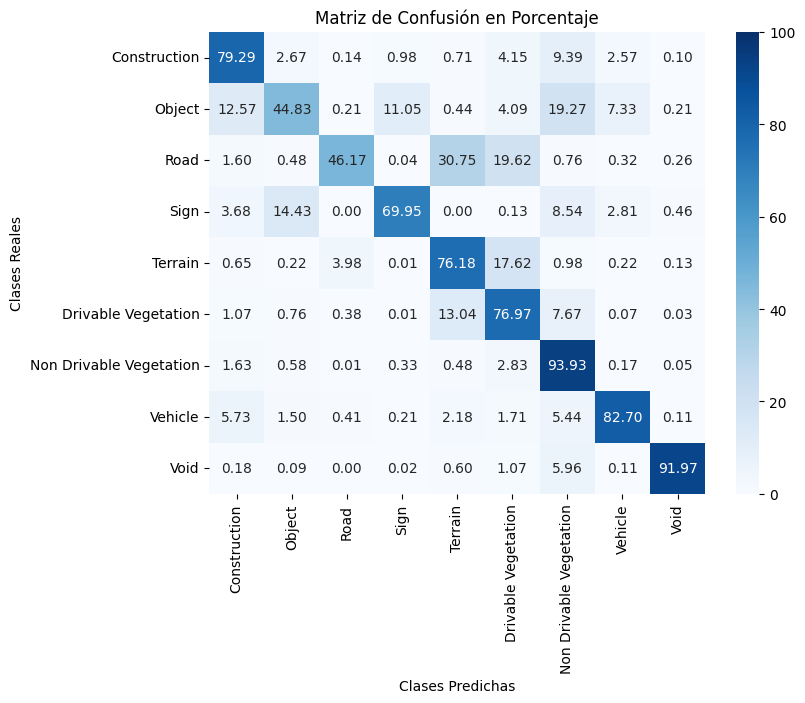

In [64]:
plot_confusion_matrix_percentage(preds_con, labels_list, num_classes=9)

In [65]:
visualizar_comparacion_segmentacion(points_list, labels_list, preds_list, indice=920)

In [66]:
import torch

# Guardar los pesos del modelo
torch.save(model.state_dict(), 'pointnet2_remission_v0.pth')